## Questão 4 (3.3 pontos)


[Solução da questão](../p2_20/scripts/Q4_formas.py)


[Vídeo do gabarito](https://youtu.be/hxMqlZmcrXk)



A sua esfera designada serã da seguinte forma

*Escreva seu RA na prova*

Se seu RA for impar, a esfera serã verde

Se seu RA for par, a esfera serã azul



#### O que é para fazer

Um código que faz o robô chegar e 1.0 m perto da sua esfera designada e parar. Você deve usar para tal uma combinação de *laser* e câmera. 

#### Detalhes de como rodar


O código para este exercício está em: `p2_20/scripts/Q4_formas.py`

Para rodar, recomendamos que faça:

    roslaunch my_simulation formas.launch

Depois:

    rosrun p1_20 Q4_formas.py



|Resultado| Conceito| 
|---|---|
| Não executa | 0 |
| Consegue segmentar os pixels em objetos sem identificar sua esfera | 1.0 |
| Identifica qual a esfera correta | 2.0 |
| Faz a abordagem baseada em câmera e laser para se aproximar corretamente | 3.3 | 


Casos intermediários ou omissos da rubrica serão decididos pelo professor.

# Solução da parte OpenCV

O código que deve fazer o robô parar próximo da esfera desejada vai ser muito parecido com a [atividade 4](https://github.com/Insper/robot20/blob/master/aula04/Atividade04.md).

Neste notebook vamos nos concentrar na parte em OpenCV.

Vamos nos lembrar que os objetos têm cores primárias. Deve entar ser simples segmentá-los usando um misto de separação por canais e *threshold* (limiarização), como na [questão 2 da Prova 1 2020](https://github.com/mirwox/prova1_2020/blob/solution/q2/Solucao_Q2.ipynb).

In [1]:
from __future__ import print_function, division

import cv2
import numpy as np
import imlib
import os
import os.path
import matplotlib.pyplot as plt

import imutils # pip install imutils
import math
%matplotlib inline

print("Versao da Cv2 ", cv2.__version__)
import sys
print("Versao do Python", sys.version)
# print("Diretório de trabalho: ", os.getcwd()) # Descomente para verificar onde está trabalhando

# Para o color picker funcionar
from ipywidgets import widgets, interact, interactive, FloatSlider, IntSlider

import auxiliar as aux


def multiplot(imgs, legenda):
    """ Função que plota n imagens BGR em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,5))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
        return
    for i in range(len(imgs)):
        axes[i].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        
def multiplot_gray(imgs, legenda):
    """ Função que plota n imagens grayscale em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,5))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0],  vmin=0, vmax=255, cmap="Greys_r"))
        return
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], vmin=0, vmax=255, cmap="Greys_r")
        
def show(img):
    print(img.shape)
    plt.figure()
    plt.imshow(imutils.opencv2matplotlib(img))


Versao da Cv2  4.2.0
Versao do Python 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]
Este script não deve ser executado diretamente


In [2]:
frames = [cv2.imread("frames/{}".format(f)) for f in "s0.png  s1.png  s2.png  s3.png  s4.png  s5.png".split() ]

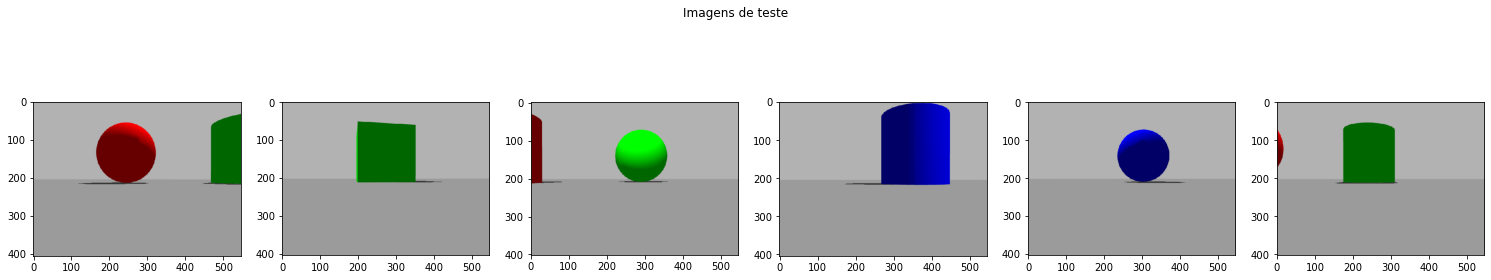

In [3]:
multiplot(frames, "Imagens de teste")

Vamos validar a ideia de que a imagem é facilmente separável por canais de cores primárias aplicando uma separação por canais e limiar:

In [4]:
def rgb(img_bgr):
    img = img_bgr
    b = img[:,:,0]
    g = img[:,:,1]
    r = img[:,:,2]    
    multiplot_gray([b,g,r],  "Canais BGR")
        

def RGB_threshold(img_bgr):
    img = img_bgr
    limiar = 175
    b = img[:,:,0]
    g = img[:,:,1]
    r = img[:,:,2]
    ret, b = cv2.threshold(b, limiar, 255, cv2.THRESH_BINARY)
    ret, g = cv2.threshold(g, limiar, 255, cv2.THRESH_BINARY)    
    ret, r = cv2.threshold(r, limiar, 255, cv2.THRESH_BINARY)
    multiplot_gray([b,g,r],  "Canais BGR")
    

Vemos abaixo que os objetos são mais escuros que o fundo cinza ao redor. Temos duas opções de como consertar:
* Trocar o fundo do gazebo para preto nas opções Scene -> Background
* Fazer seleção de cores com `inRange`


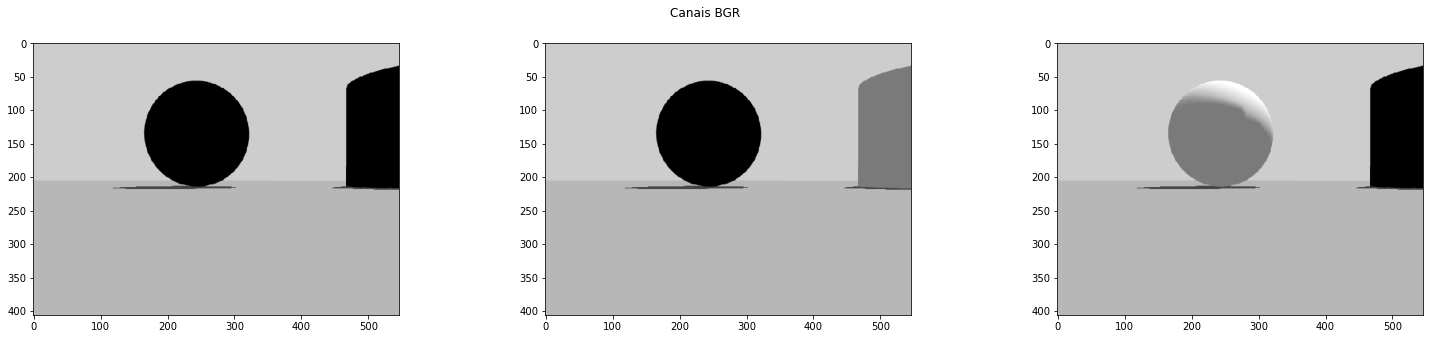

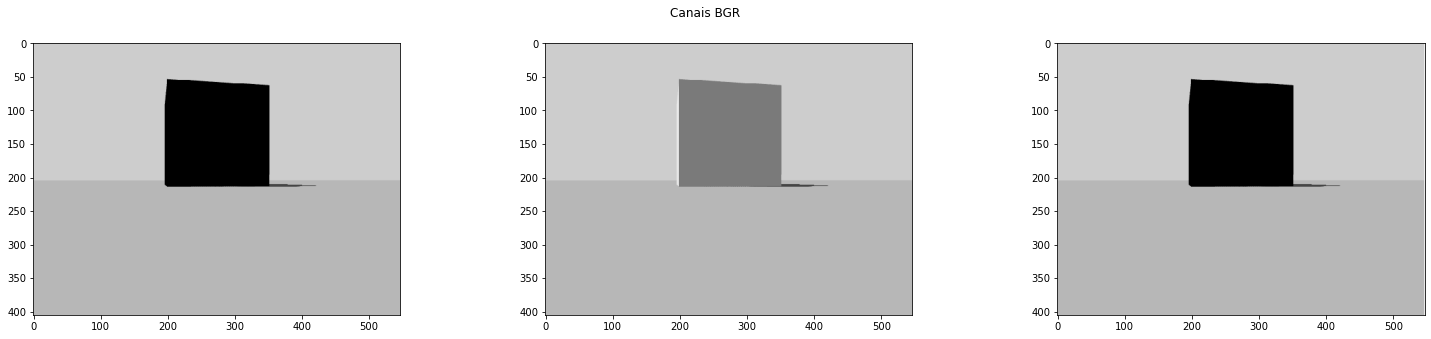

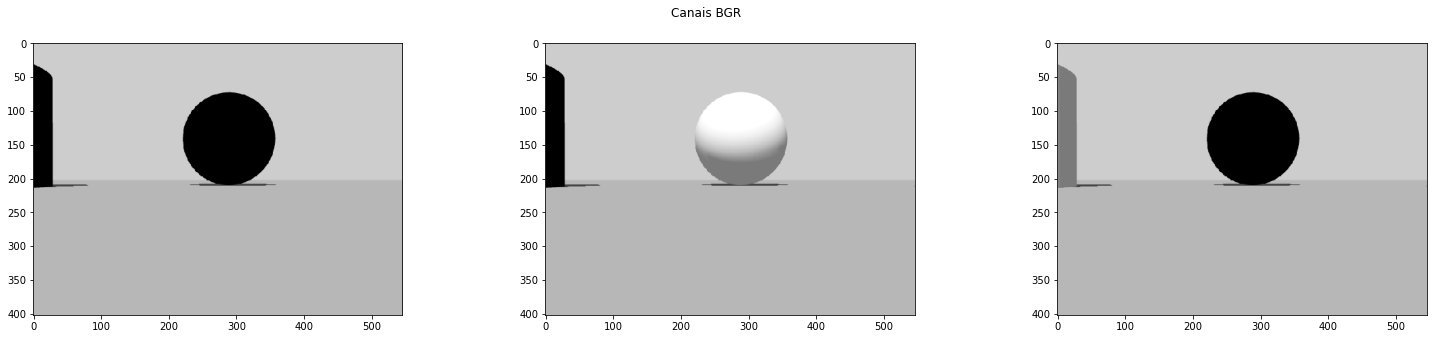

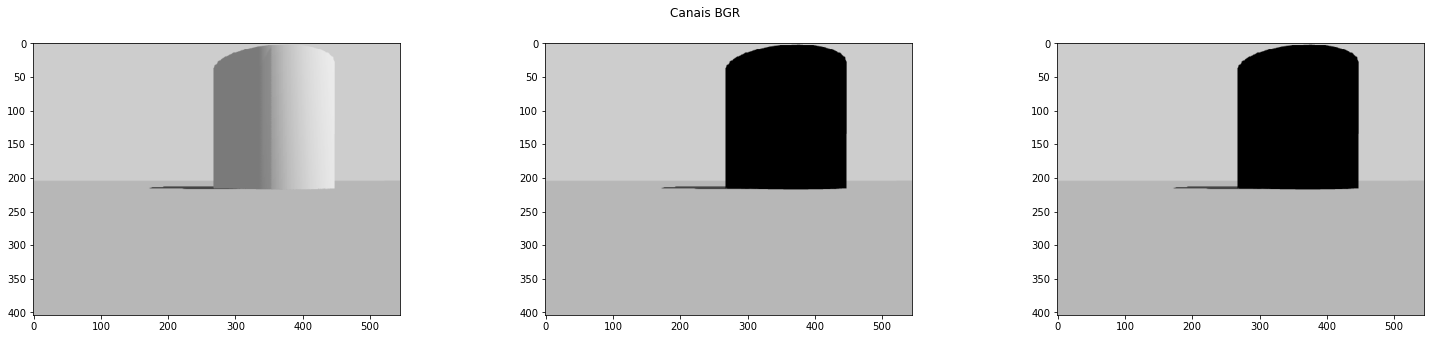

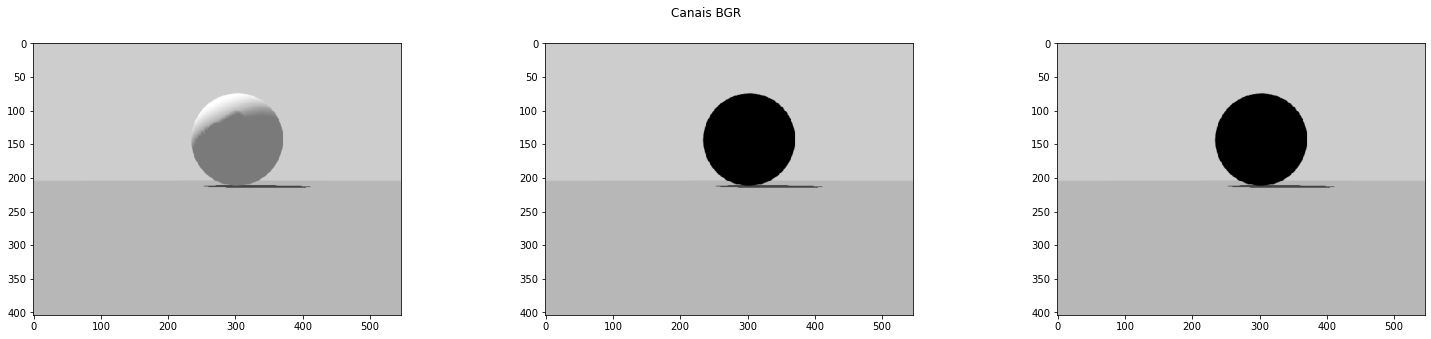

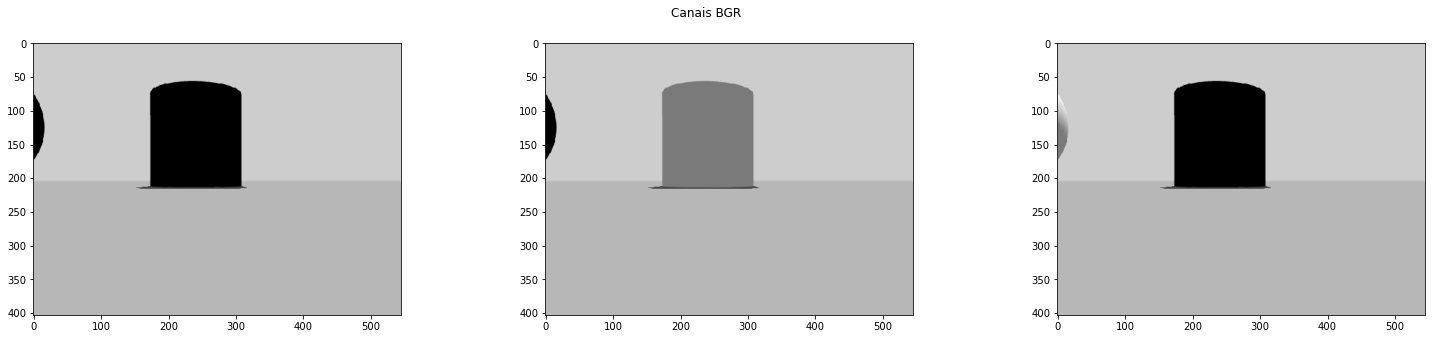

In [5]:
for f in frames:
    rgb(f)

Nesta solução vamos selecionar as cores com inRange porque é a maneira mais vista na disciplina

Vamos criar um color picker para cada cor necessária.


In [6]:
g_colorpicker = widgets.ColorPicker(
    concise=False,
    description='Escolha uma cor',
    value='#00ff00',
    disabled=False
)

In [7]:
b_colorpicker = widgets.ColorPicker(
    concise=False,
    description='Escolha uma cor',
    value='#0000ff',
    disabled=False
)


In [8]:
g_colorpicker

ColorPicker(value='#00ff00', description='Escolha uma cor')

In [9]:
b_colorpicker

ColorPicker(value='#0000ff', description='Escolha uma cor')

In [11]:
g1, g2 = aux.ranges(g_colorpicker.value)
b1, b2 = aux.ranges(b_colorpicker.value)

In [12]:
def mask(hsv, a1, a2):
    return cv2.inRange(hsv, a1, a2)

In [13]:
g1,g2

(array([50, 50, 50], dtype=uint8), array([ 60, 255, 255], dtype=uint8))

In [14]:
b1,b2

(array([110,  50,  50], dtype=uint8), array([120, 255, 255], dtype=uint8))

## Ajustes nos limites do inRange

A seleção acima deixou alguns pontos falhos quando o ROS foi usados. Por conta deste motivo, houve um ajuste nos valores

In [33]:
from numpy import array, uint8

In [34]:
g1, g2 = (array([45, 80, 20], dtype=uint8), array([ 65, 255, 255], dtype=uint8))
b1, b2 = (array([105,  80,  20], dtype=uint8), array([125, 255, 255], dtype=uint8))

In [17]:
def processa(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    blue = mask(hsv, b1,b2)
    green = mask(hsv, g1, g2)
    show(img_bgr)
    multiplot_gray([blue, green], "BLUE GREEN")

## Visualizando o resultado do inRange

Felizmente as imagens têm excelente contraste e foi fácil separar os objetos azuis e verdes

(406, 546, 3)
(405, 547, 3)
(402, 546, 3)
(404, 545, 3)
(404, 546, 3)
(403, 545, 3)


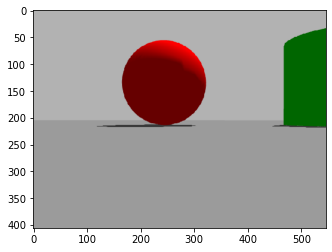

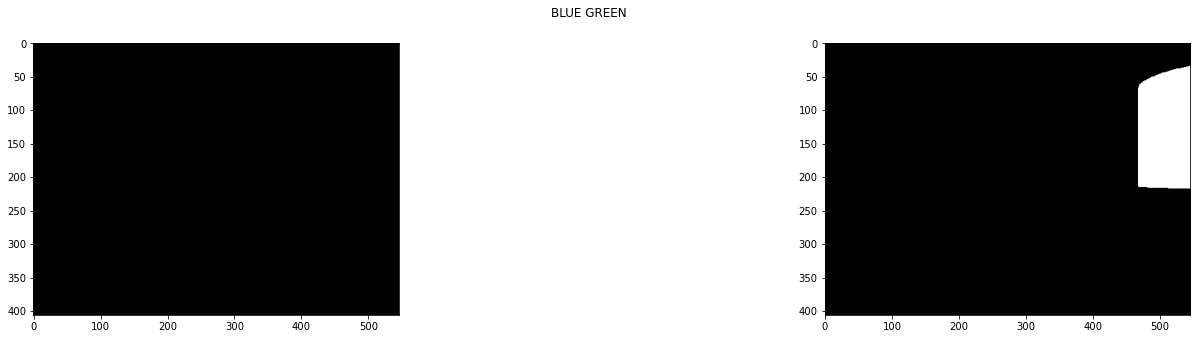

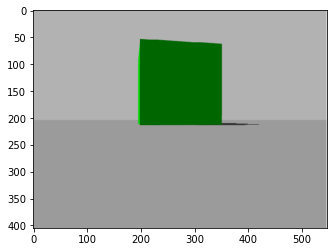

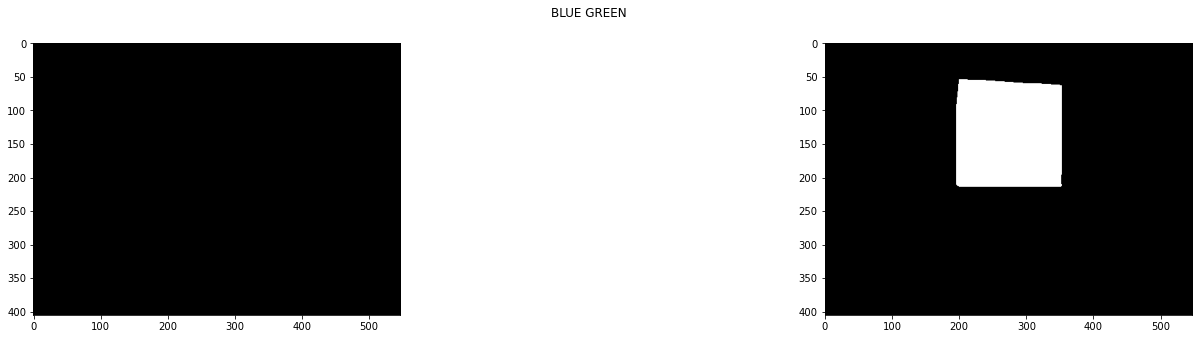

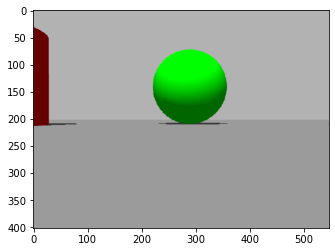

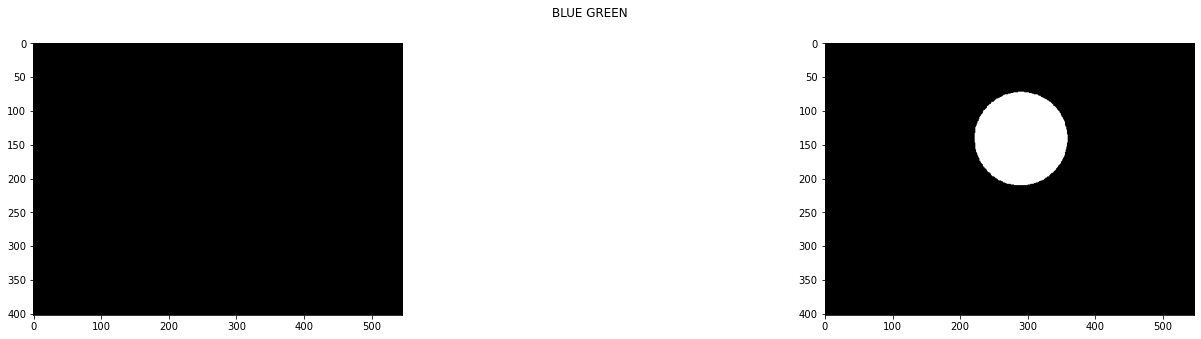

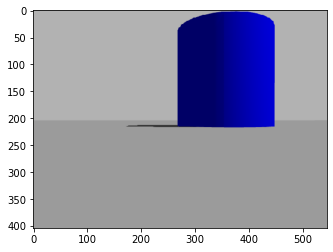

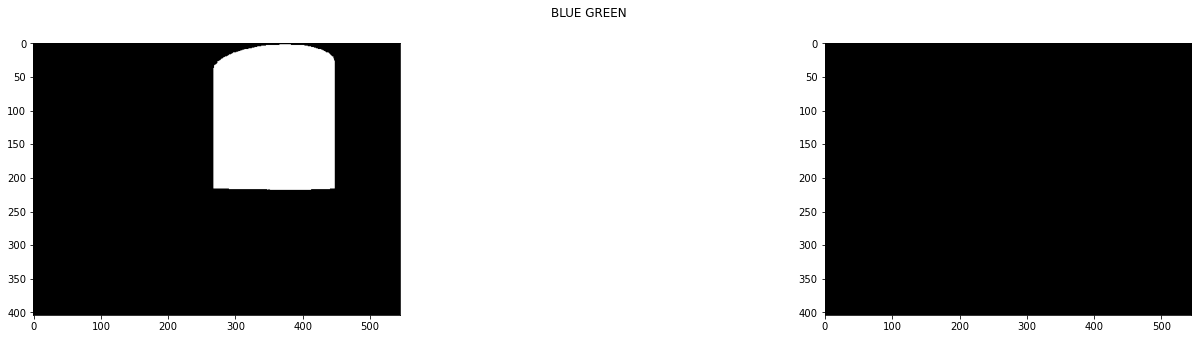

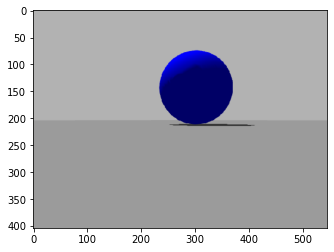

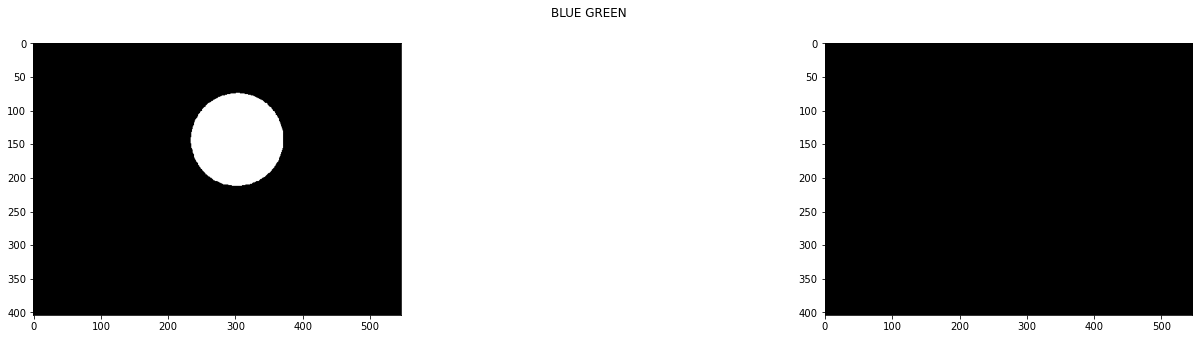

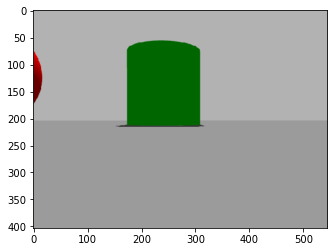

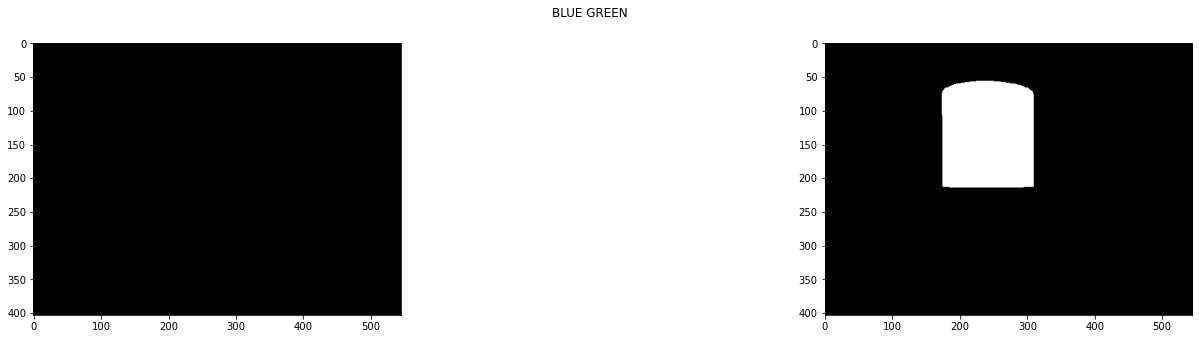

In [18]:
for f in frames:
    processa(f)

## Identificando círculos

Após a separação por canais, precisamos verificar se existem círculos nas imagens. Desta forma conseguiremos separar a esfera do cilindro



In [29]:

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged


def maior_circulo(mask, color):
    """ Retorna os dados do maior círculo existente na imagem. E uma imagem com este círculo desenhado"""
    tem_circulo = False
    maior_centro = (0,0)
    maior_raio = 0
    
    bordas = auto_canny(mask)
    
    circles=cv2.HoughCircles(image=bordas,method=cv2.HOUGH_GRADIENT,dp=2.5,
                             minDist=40,param1=50,param2=100,minRadius=5,maxRadius=150)
    
    
    bordas_bgr = cv2.cvtColor(bordas, cv2.COLOR_GRAY2RGB)
 
    output =  bordas_bgr

    if circles is not None:        
        circles = np.uint16(np.around(circles))
        
        for i in circles[0,:]:
            tem_circulo = True
            # draw the outer circle
            cv2.circle(output,(i[0],i[1]),i[2],color,2)
            # draw the center of the circle
            cv2.circle(output,(i[0],i[1]),2,color,3)
            if i[2] > maior_raio:
                maior_centro = (int(i[0]), int(i[1]))
                                
    return tem_circulo, maior_centro, maior_raio, output

def detecta(mask, color):
    tem, centro, raio, img = maior_circulo(mask, color)
    show(img)

Vamos combinar o que foi exposto até agora:


In [30]:
def processa_circulos(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    blue = mask(hsv, b1,b2)
    green = mask(hsv, g1, g2)
    detecta(blue, (255,0,0))
    detecta(green, (0,255,0))
    
    
    

### Resultado incluindo deteção de círculos

(406, 546, 3)
(406, 546, 3)
(405, 547, 3)
(405, 547, 3)
(402, 546, 3)
(402, 546, 3)
(404, 545, 3)
(404, 545, 3)
(404, 546, 3)
(404, 546, 3)
(403, 545, 3)
(403, 545, 3)


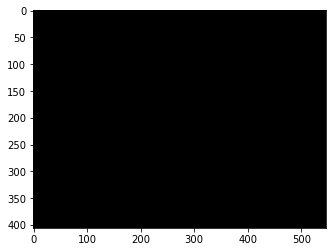

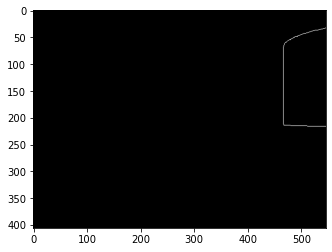

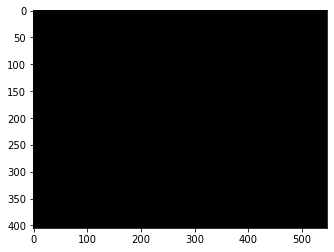

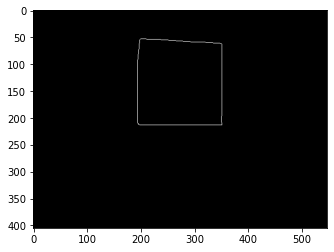

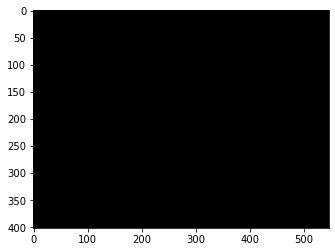

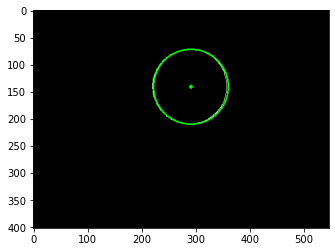

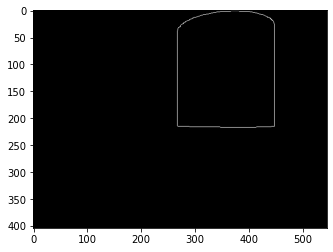

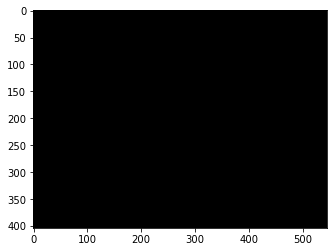

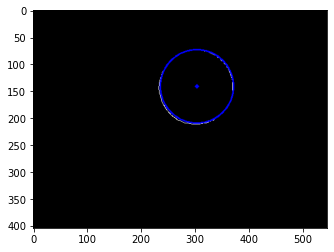

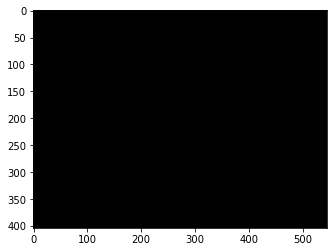

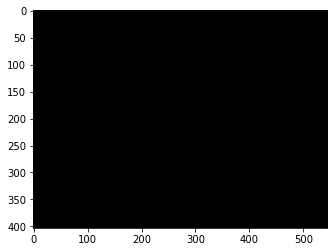

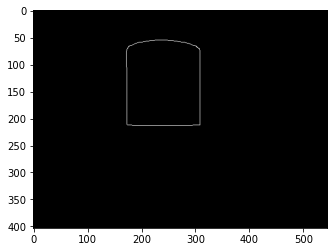

In [31]:
for f in frames:
    processa_circulos(f)

In [32]:
def processa_circulos_controle(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    blue = mask(hsv, b1,b2)
    green = mask(hsv, g1, g2)
    cor_b = (255,0,0)
    cor_g = (0,255,0)
    tem_blue, centro_b, raio_n, img_b = maior_circulo(blue, cor_b)
    tem_green, centro_g, raio_g, img_g = maior_circulo(green, cor_g)
    
    delta_blue = centro_b[0] - 320 # quão afastado está do centro da tela de 640 x 480
    delta_green = centro_g[0] - 320 # quão afastado está do centro da tela de 640 x 480
    
    
    
    

# Continuação no ROS

Agora caímos num caso muito parecido com a Atividade 4. Precisamos fazer o robô centralizar no círculo e em seguida se aproximar, controlando a aproximação via laser.